<a href="https://colab.research.google.com/github/oluwafemidiakhoa/Mindserach/blob/master/Vastnessofstars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
!pip install astroquery

In [78]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [79]:
# Define coordinates and radius for the search
ra = 194.95  # Right Ascension
dec = 27.98  # Declination
coord = coords.SkyCoord(ra, dec, unit="deg")
radius = coords.Angle(2, unit="arcmin")  # Radius for the search

# Query the SDSS database
xid = SDSS.query_region(coord, radius=radius, spectro=True)

# Fetching the spectra data
spectra = SDSS.get_spectra(matches=xid)


In [80]:
# Extracting flux data and padding to uniform length
max_length = max([len(sp[1].data['flux']) for sp in spectra])
spectra_data = [np.pad(sp[1].data['flux'], (0, max_length - len(sp[1].data['flux'])), 'constant') for sp in spectra]

# Convert to numpy array
spectra_data = np.array(spectra_data)

# Normalize the spectra data
scaler = StandardScaler()
spectra_data_normalized = scaler.fit_transform(spectra_data)


In [81]:
class VAEModel(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(VAEModel, self).__init__()
        self.encoder_dense1 = layers.Dense(128, activation='relu')
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)
        self.sampling_layer = layers.Lambda(self.sampling)
        self.decoder_dense1 = layers.Dense(128, activation='relu')
        self.decoder_output = layers.Dense(input_dim, activation='sigmoid')

    def sampling(self, args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], tf.keras.backend.int_shape(z_mean)[1]))
        return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        h = self.encoder_dense1(inputs)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        z = self.sampling_layer([z_mean, z_log_var])
        h_decoded = self.decoder_dense1(z)
        x_decoded_mean = self.decoder_output(h_decoded)

        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.add_loss(kl_loss)

        return x_decoded_mean

input_dim = spectra_data_normalized.shape[1]
latent_dim = 64
vae = VAEModel(input_dim=input_dim, latent_dim=latent_dim)


In [82]:
# Define the encoder model separately
def build_encoder(vae_model):
    inputs = layers.Input(shape=(input_dim,))
    h = vae_model.encoder_dense1(inputs)
    z_mean = vae_model.z_mean(h)
    encoder = models.Model(inputs, z_mean, name="encoder")
    return encoder

# Instantiate the encoder model
encoder = build_encoder(vae)


In [83]:
# Compile and train the VAE model
vae.compile(optimizer='adam', loss='binary_crossentropy')
vae.fit(spectra_data_normalized, spectra_data_normalized, epochs=50, batch_size=256)

# Use the encoder to transform data
encoded_data = encoder.predict(spectra_data_normalized)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 735.1075
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 34756.0898
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 7612.0420
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 237436.1406
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 34758.0234
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 66909.9375
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 49298.2500
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 66373.9688
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 68111.5391
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 72554.7969
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 35544.6055
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 25917.7871
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 28032.4004
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 36104.1953
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [84]:
class TransformerEncoderClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, nhead=8, num_layers=2, dim_feedforward=128):
        super(TransformerEncoderClassifier, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

num_classes = 5  # Number of classes for stellar evolution stages
input_dim = encoded_data.shape[1]
model = TransformerEncoderClassifier(input_dim=input_dim, num_classes=num_classes)


In [85]:
labels = np.random.randint(0, num_classes, size=len(encoded_data))  # Dummy labels for illustration
dataset = TensorDataset(torch.tensor(encoded_data, dtype=torch.float32), torch.tensor(labels, dtype=torch.long))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for batch in dataloader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 1.7299103736877441
Epoch 2, Loss: 1.333020567893982
Epoch 3, Loss: 1.2936573028564453
Epoch 4, Loss: 1.1479729413986206
Epoch 5, Loss: 0.9933729767799377
Epoch 6, Loss: 0.9364988803863525
Epoch 7, Loss: 0.8939491510391235
Epoch 8, Loss: 0.7759041786193848
Epoch 9, Loss: 0.767413854598999
Epoch 10, Loss: 0.6779428124427795


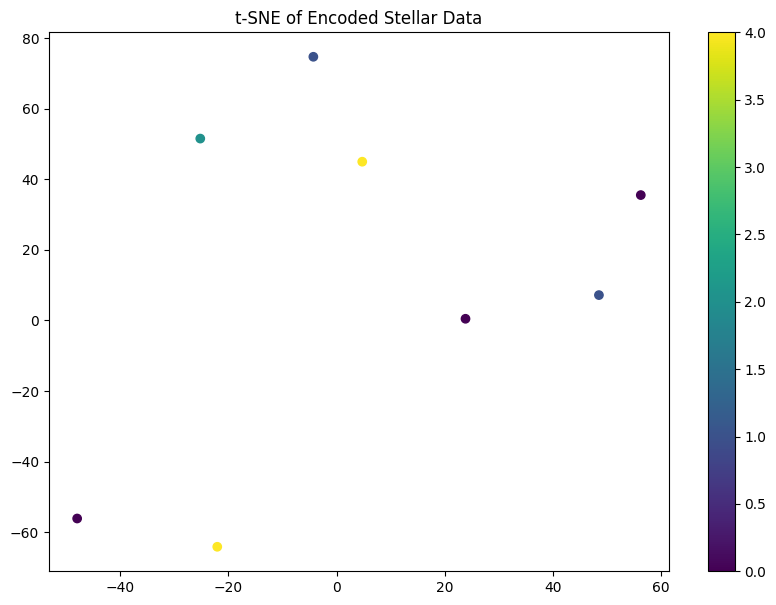

In [87]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Set perplexity to a smaller value, such as 5 or 10
n_samples = encoded_data.shape[0]
perplexity_value = min(30, n_samples // 2)

# Perform t-SNE on encoded data with updated perplexity
tsne = TSNE(n_components=2, perplexity=perplexity_value, n_iter=300)
encoded_2d = tsne.fit_transform(encoded_data)

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE of Encoded Stellar Data')
plt.show()
